Run this cell load the autoreload extension. This allows us to edit .py source files, and re-import them into the notebook for a seamless editing and debugging experience.

In [ ]:
%load_ext autoreload
%autoreload 2

Run the following cell to mount your Google Drive. Follow the link, sign in to your Google account (the same account you used to store this notebook!) and copy the authorization code into the text box that appears below.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Locating the path to the project

In [ ]:
import os

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Predictive_Maintenance_Bearings'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)

print(os.listdir(GOOGLE_DRIVE_PATH))

['__pycache__', '.ipynb_checkpoints', 'Back', 'preprocessing', 'data', 'plot3d.xlsx', 'Models', 'Results', 'Source_domain.pth', 'transfer_learning.py', 'cnn_architecture.py', 'Source_domain_FE_norm.pth', 'Inference.ipynb', 'optimize.py', 'Target_Network.ipynb', 'Source_Network.ipynb', 'Source_mixed12k.pth']


In [ ]:
import sys
sys.path.append(GOOGLE_DRIVE_PATH)

import time, os
os.environ["TZ"] = "US/Eastern"
time.tzset()

Import packages required for this file and set the default figure size

In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt
import random
import time
import math
import torchvision.models as models
from torchvision import datasets, transforms
import pandas as pd
from tqdm.auto import tqdm
import multiprocessing

%matplotlib inline

plt.rcParams["figure.figsize"] = (10.0, 8.0)  # set default size of plots
plt.rcParams["font.size"] = 16
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gray"

Use this cell to ensure cuda is available on colab.

In [ ]:
if torch.cuda.is_available:
  print('Good to go!')
else:
  print('Please set GPU via Edit -> Notebook Settings')

Good to go!


Computing mean and std's for the training set only, so as to ensure information from validation and test does not leak into the training set. We will normalize the validation and test with the same values of mean and std as obtained from training.

In [ ]:
import multiprocessing

torch.manual_seed(0)

data_transforms = {
    'Train': transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.RandomAdjustSharpness(1),
                transforms.Normalize([0., 0., 0.], [1., 1., 1.])
            ])
        }

data_dir = os.path.join(GOOGLE_DRIVE_PATH, 'data/CWRU/New_Data/mixed12k')
# print(os.listdir(data_dir + '/Train'))
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['Train']}

NUM_WORKERS = multiprocessing.cpu_count()
BATCH_SIZE = 4

image_dataloader = torch.utils.data.DataLoader(dataset = image_datasets['Train'], batch_size = BATCH_SIZE, 
                                               num_workers = NUM_WORKERS, pin_memory = True, shuffle = False)

In [ ]:
# Compute Mean and Std's
psum    = torch.tensor([0.0, 0.0, 0.0])
psum_sq = torch.tensor([0.0, 0.0, 0.0])

for i, data in tqdm(enumerate(image_dataloader), total=len(image_dataloader)):
    images, labels = data
    psum    += images.sum(axis = [0, 2, 3])
    psum_sq += (images ** 2).sum(axis = [0, 2, 3])

image_size = 224
count = len(image_datasets['Train'])*image_size*image_size
print(psum)
print(psum_sq)
print(count)

  0%|          | 0/2787 [00:00<?, ?it/s]

tensor([1.3359e+08, 1.4087e+08, 2.6270e+08])
tensor([3.2742e+07, 4.8976e+07, 1.2568e+08])
559261696


In [ ]:
total_mean = psum/count
total_var = (psum/count) - (total_mean**2)
total_std = torch.sqrt(total_var)

print(f"Mean of the dataset is :                {total_mean}")
print(f"Standard Deviation for the dataset is : {total_std}")

Mean of the dataset is :                tensor([0.2389, 0.2519, 0.4697])
Standard Deviation for the dataset is : tensor([0.4264, 0.4341, 0.4991])


Mean = torch.tensor([0.2389, 0.2519, 0.4697]) <br>
Std = torch.tensor([0.4264, 0.4341, 0.4991]) <br>

In [ ]:
torch.manual_seed(0)

# Data Augmentations performed - extremely basic just resizing to image dimension to 3x224x224 and sharpening the images to ensure image resolution is not lost

data_transforms = {
    'Train': transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.RandomAdjustSharpness(1),
                transforms.Normalize(total_mean, total_std)
            #   transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'Val': transforms.Compose([
                  transforms.Resize((224, 224)),
                  transforms.ToTensor(),
                  transforms.RandomAdjustSharpness(1),
                  transforms.Normalize(total_mean, total_std)
          #       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'Test': transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.RandomAdjustSharpness(1),
            transforms.Normalize(total_mean, total_std)
          # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# Load data from disk

NUM_WORKERS = multiprocessing.cpu_count()
BATCH_SIZE = 4

data_dir = os.path.join(GOOGLE_DRIVE_PATH, 'data/CWRU/New_Data/mixed12k')
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['Train', 'Val', 'Test']}

# Training Dataloader
train_dataloader = torch.utils.data.DataLoader(dataset = image_datasets['Train'], batch_size = BATCH_SIZE, 
                                               num_workers = NUM_WORKERS, pin_memory = True, shuffle = True)
# Validation Dataloader
val_dataloader = torch.utils.data.DataLoader(dataset = image_datasets['Val'], batch_size = BATCH_SIZE, 
                                             num_workers = NUM_WORKERS, pin_memory = True, shuffle = False)
# Test Dataloader
test_dataloader = torch.utils.data.DataLoader(dataset = image_datasets['Test'], batch_size = BATCH_SIZE, 
                                              num_workers = NUM_WORKERS, pin_memory = True, shuffle = False)

train_loader_iter = iter(train_dataloader)
image, batches = next(train_loader_iter)
dataset_sizes = {x: len(image_datasets[x]) for x in ['Train', 'Val', 'Test']}
path_classes_train = {x: len(os.listdir(os.path.join(data_dir, 'Train/'+ x))) for x in ['Faulty', 'Healthy']}
path_classes_val = {x: len(os.listdir(os.path.join(data_dir, 'Val/'+ x))) for x in ['Faulty', 'Healthy']}
path_classes_test = {x: len(os.listdir(os.path.join(data_dir, 'Test/'+ x))) for x in ['Faulty', 'Healthy']}

class_names = image_datasets['Train'].classes

B, C, H, W = image.shape[0], image.shape[1], image.shape[2], image.shape[3]

print(f"image has shape (B, C, H, W): {image.shape}")
print(f"image batch has shape       : {batches.shape}")
print(f"dataset_sizes               : {dataset_sizes}")
print(f"Training class              : {path_classes_train}")
print(f"Val class                   : {path_classes_val}")
print(f"Test class                  : {path_classes_test}")
print(f"Class names                 : {class_names}")

image has shape (B, C, H, W): torch.Size([4, 3, 224, 224])
image batch has shape       : torch.Size([4])
dataset_sizes               : {'Train': 11146, 'Val': 2800, 'Test': 3500}
Training class              : {'Faulty': 5572, 'Healthy': 5574}
Val class                   : {'Faulty': 1400, 'Healthy': 1400}
Test class                  : {'Faulty': 1750, 'Healthy': 1750}
Class names                 : ['Faulty', 'Healthy']


In [ ]:
import time
import torch.nn as nn
from cnn_architecture import CNN_Architecture
from optimize import SaveBestModel, train_model, val_model
import torch.optim as optim

torch.manual_seed(0)

DEVICE = torch.device("cuda")
# Network of CNN Model
bn_model = CNN_Architecture(input_dims=(C, H, W), num_classes=2,
                            dtype=torch.float32, device=DEVICE)
bn_model = bn_model.to(DEVICE)

# Calculate the total trainable parameters in the model
total_params = sum(p.numel() for p in bn_model.parameters())
print(f"{total_params:,} total parameters.")

194,243,618 total parameters.


In [ ]:
import time
import torch.nn as nn
from cnn_architecture import CNN_Architecture
from optimize import SaveBestModel, train_model, val_model
import torch.optim as optim
from torch.optim import lr_scheduler

torch.manual_seed(0)

DEVICE = torch.device("cuda")
# Network of CNN Model
bn_model = CNN_Architecture(input_dims=(C, H, W), num_classes=2,
                            dtype=torch.float32, device=DEVICE)
bn_model = bn_model.to(DEVICE)

# Loss Criterion and Optimizer for the Model
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(bn_model.parameters(), lr=1e-4, betas=(0.9, 0.999), 
                       weight_decay= 0.001, amsgrad=False)
# scheduler = lr_scheduler.LinearLR(optimizer)

# initialize SaveBestModel class
save_best_model = SaveBestModel(model=bn_model, optimizer=optimizer, criterion=criterion,
                                path = GOOGLE_DRIVE_PATH)

NUM_EPOCHS = 20

# Used for plotting loss and acc
train_loss, val_loss = [], []
train_acc, val_acc = [], [] 

# Main Training and Validation Loop
for epoch in range(NUM_EPOCHS):
    print(f'Epoch {epoch+1} of {NUM_EPOCHS}')
    train_epoch_loss, train_epoch_acc = train_model(bn_model, train_dataloader, 
                                                    optimizer, criterion, DEVICE)
    val_epoch_loss, val_epoch_acc = val_model(bn_model, val_dataloader, 
                                              criterion, DEVICE)

    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    train_acc.append(train_epoch_acc)
    val_acc.append(val_epoch_acc)

    print(f'Training loss: {train_epoch_loss:.3f} and Training Acc: {train_epoch_acc:.3f}')
    print(f'Val loss: {val_epoch_loss:.3f} and Val Acc: {val_epoch_acc:.3f}')

    best_model = save_best_model.best_loss(val_epoch_loss, val_epoch_acc, epoch)

    print('-'*50)

    # Break the training loop if the results on validation is either 0 loss or 100% accuracy
    if val_epoch_loss == 0.0 or val_epoch_acc == 100.0:
      break
    else: 
      continue

print('Finished Training')

194,243,618 total parameters.
Epoch 1 of 20
Training


  0%|          | 0/2787 [00:00<?, ?it/s]

Validation


  0%|          | 0/700 [00:00<?, ?it/s]

Training loss: 3.228 and Training Acc: 98.134
Val loss: 0.000 and Val Acc: 100.000

Best validation loss and acc: 0.0

Saving best model for epoch: 1

file saved to drive/My Drive/Predictive_Maintenance_Bearings/Source_mixed12k.pth
--------------------------------------------------
Finished Training


Plotting the Train and Validation Loss

<function matplotlib.pyplot.show(close=None, block=None)>

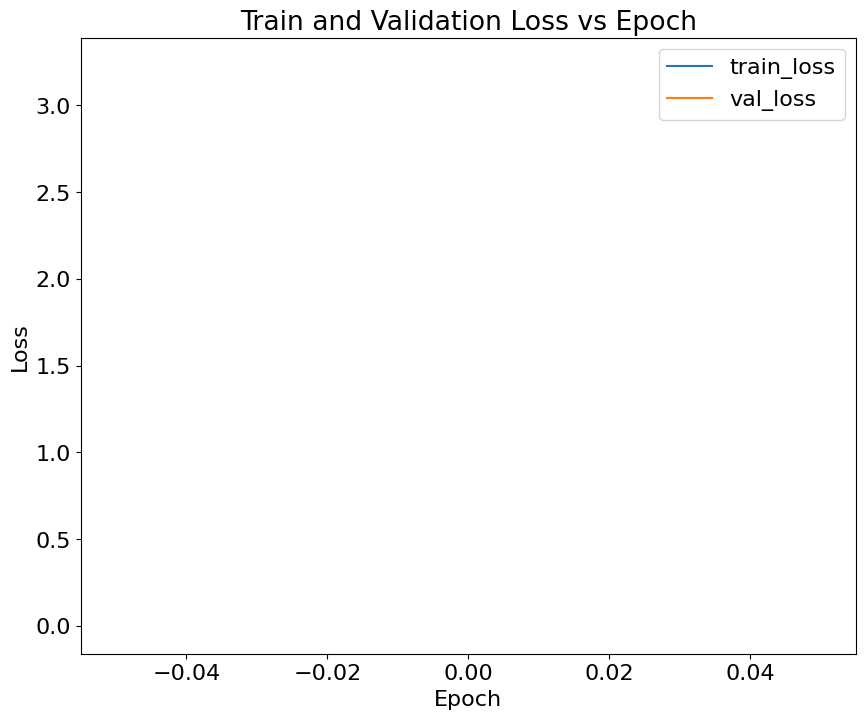

In [ ]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10.0, 8.0)  # set default size of plots
plt.rcParams["font.size"] = 16
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gray"

plt.plot(train_loss, label='train_loss')
plt.plot(val_loss, label='val_loss')
plt.title('Train and Validation Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig(os.path.join(GOOGLE_DRIVE_PATH, 'Results/Source_domain_mixed12k.png'))
plt.show

**Inference Source**

Do not run inference without completing training and validation.


In [ ]:
import os

DEVICE = torch.device("cuda")
# Path to weight
PATH = os.path.join(GOOGLE_DRIVE_PATH, 'Source_mixed12k.pth')
test_model = CNN_Architecture(input_dims=(C, H, W), num_classes=2, 
                              dtype=torch.float32, device=DEVICE)

test_model = test_model.to(DEVICE)
# Load the model
checkpoint = torch.load(PATH)
test_model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

The Next two cells are just to check whether inference is working and to get a visual output of the results.

GroundTruth:  Faulty Faulty Faulty Faulty


<ipython-input-24-fe96d5d889b1>:13: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 5, i+1).set_title(f'{classes[labels[i]]}')


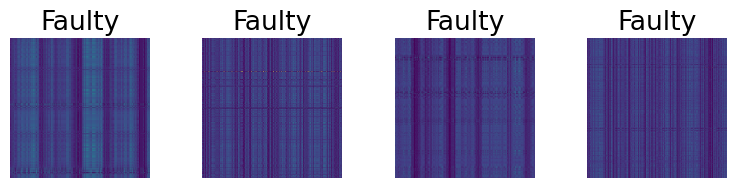

In [ ]:
dataiter = iter(test_dataloader)
images, labels = next(dataiter)

classes = ['Faulty', 'Healthy']
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(BATCH_SIZE)))
fig, axes = plt.subplots(1, 4, figsize=(12, 4))

mean = total_mean
std = total_std
for i in range(images.shape[0]):
  im = images[i, :, :, :]
  im = im*std.view(3,1,1) + mean.view(3,1,1)
  plt.subplot(2, 5, i+1).set_title(f'{classes[labels[i]]}')
  plt.imshow(torch.permute(im, (1,2,0)))
  plt.axis('off')

In [ ]:
torch.manual_seed(0)

test_model.eval()
images = images.to(DEVICE)
outputs = test_model(images)

_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'for j in range(len(images))))

Predicted:  Faulty Faulty Faulty Faulty


In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
torch.manual_seed(0)


with torch.no_grad():
  for data in test_dataloader:
        images, labels = data
        # calculate outputs by running images through the network
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = test_model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print(f'Accuracy of the network with test images of: {100 * correct / total} %')

Accuracy of the network with test images of: 100.0 %


Accuracy of the network with test images of: 100.0 %


